In [38]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

from ro5utils.aws.s3 import download_s3_directory, upload_s3_file

from mapk1_processing import read_data, get_joint_df, parse_decaf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading data

In [39]:
MAPK1_DIR = Path("/Users/povilas/projects/2021-10_Strateos/data/mapk1/")
PROCESSED_OUTPUTS = MAPK1_DIR / "processed_outputs"

In [8]:
# download_s3_directory("strateos",
#                       "data/mapk1/processed_outputs",
#                       PROCESSED_OUTPUTS)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:ro5utils.aws.s3:Downloading from S3://strateos/data/mapk1/processed_outputs to local directory /Users/povilas/projects/2021-10_Strateos/data/mapk1/processed_outputs...
100%|█████████████████████████████████████████████████████████████| 4/4 [02:41<00:00, 40.47s/it]


[PosixPath('/Users/povilas/projects/2021-10_Strateos/data/mapk1/processed_outputs/mapk1_pharmit.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/data/mapk1/processed_outputs/mapk1_shape_decaf.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/data/mapk1/processed_outputs/mapk1_shape_usrcat.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/data/mapk1/processed_outputs/mapk1_tanimoto.csv')]

In [58]:
tani = read_data("tanimoto", data_dir=PROCESSED_OUTPUTS)

In [59]:
tani.head()

name  hypothesis  score     label  method_rank  \
0  57906_57942_Inactive  4ZXT_A_CAQ    1.0  Inactive            1   
1  19171_19195_Inactive  4QP2_A_36R    1.0  Inactive            2   
2  69366_69407_Inactive  4QP2_A_36R    1.0  Inactive            3   
3  24671_24695_Inactive  4N0S_A_DHC    1.0  Inactive            4   
4  57494_57530_Inactive  4N0S_A_DHC    1.0  Inactive            5   

   hypothesis_rank  compound_rank  conservative_label  liberal_label  
0                1              1                   0              0  
1                1              1                   0              0  
2                2              1                   0              0  
3                1              1                   0              0  
4                2              1                   0              0

# Needs to be joined with other data

In [56]:
df = read_data("decaf_public", data_dir=PROCESSED_OUTPUTS)

In [60]:
df["method"] = "decaf_public"

In [61]:
df.to_csv(MAPK1_DIR/"mapk1_decaf_clean.csv.gz")

In [9]:
joint_df = get_joint_df(data_dir=PROCESSED_OUTPUTS)

/Users/povilas/code/strateos/results/mapk1/mapk1_processing.py:92: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  all_tables = {method: read_data(method, data_dir=data_dir) for method in methods}


In [10]:
joint_df.shape

(21905305, 9)

In [17]:
joint_df_parquet_file = MAPK1_DIR/"mapk1_joint_results.parquet.gzip"
joint_df_csv_file = MAPK1_DIR/"mapk1_joint_results.csv.gz"

In [ ]:
# joint_df = joint_df.reset_index()=
# joint_df = joint_df.drop(columns=['level_1'])

In [31]:
joint_df.to_parquet(joint_df_parquet_file, compression='gzip') # Requires pyarrow dependency

joint_df.to_csv(joint_df_csv_file,
                header=True,
                index=False,
                chunksize=1000000,
                compression='gzip',
                encoding='utf-8')

In [32]:
upload_s3_file(joint_df_csv_file, "strateos", "data/mapk1/mapk1_joint_results.csv.gz", overwrite=True)
upload_s3_file(joint_df_parquet_file, "strateos", "data/mapk1/mapk1_joint_results.parquet.gzip", overwrite=True)

True

In [43]:
# removing stereoisomers -> ~53k datapoints left (586 of which are active)

In [48]:
# df_dict = {
#     'decaf' : read_data('decaf'),
#     'usrcat' : read_data('usrcat'),
#     'ph4' : read_data('ph4')
# }
# df_dict['tanimoto'] = read_data('tanimoto')

# Decaf parse

In [3]:
DECAF_DIR = Path("/Users/povilas/projects/2021-10_Strateos/decaf/")

In [19]:
assay_data = pd.read_csv("/Users/povilas/projects/2021-10_Strateos/data/mapk1/P28482_aggregated_data.csv")

In [5]:
list(DECAF_DIR.glob("*/*.csv"))

[PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_1/decaf_results.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_103/decaf_results.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_104/decaf_results.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_12/decaf_results.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_0/decaf_results.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_105/decaf_results.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_102/decaf_results.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_120/decaf_results.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_118/decaf_results.csv'),
 PosixPath('/Users/povilas/projects/2021-10_Strateos/decaf/assay_data_split_111/decaf_results.cs

In [30]:
df = pd.read_csv(DECAF_DIR/ "assay_data_split_0/decaf_results.csv", index_col=0)

In [31]:
df_clean = parse_decaf(df, assay_data)

In [36]:
df_clean[df_clean["query"] == "19106_19130_Inactive"]

reference                 query     score
0   mapk1_assay_set_1018  19106_19130_Inactive  0.307617
0   mapk1_assay_set_1026  19106_19130_Inactive  0.425781
0   mapk1_assay_set_1028  19106_19130_Inactive  0.333252
0   mapk1_assay_set_1020  19106_19130_Inactive  0.346680
0   mapk1_assay_set_1002  19106_19130_Inactive  0.519531
..                   ...                   ...       ...
0    mapk1_assay_set_988  19106_19130_Inactive  0.381836
0    mapk1_assay_set_986  19106_19130_Inactive  0.409180
0    mapk1_assay_set_989  19106_19130_Inactive  0.546387
0     mapk1_assay_set_99  19106_19130_Inactive  0.523926
0    mapk1_assay_set_993  19106_19130_Inactive  0.424072

[3756 rows x 3 columns]

# Hit selection based on tail or threshold

In [64]:
def select_hits(method, threshold = None, nn = 20):
    # given a threshold value or number of top elements, select the DataFrame rows containing them
    # returns dictionary of DataFrames for each reference
    hyp_to_hits = {}
    df = df_dict[method]
    
    if method == 'decaf':
        if threshold is not None:
            all_refs = [s for s in df.columns if s.endswith('_ligand')]
            for col in all_refs:
                select_df = deepcopy(df[df[col] > threshold])
                hyp_to_hits[col] = select_df
        else:
            all_refs = [s for s in df.columns if s.endswith('_ligand')]
            for col in all_refs:
                select_df = deepcopy(df.sort_values(by=col, ascending=False))
                hyp_to_hits[col] = select_df.iloc[:nn]
                
    elif method == 'usrcat':
        if threshold is not None:
            all_refs = [s for s in df.columns if s.endswith('_ligand')]
            for col in all_refs:
                select_df = deepcopy(df[df[col] > threshold])
                hyp_to_hits[col] = select_df
        else:
            all_refs = [s for s in df.columns if s.endswith('_ligand')]
            for col in all_refs:
                select_df = deepcopy(df.sort_values(by=col, ascending=False))
                hyp_to_hits[col] = select_df.iloc[:nn]
                
    elif method == 'ph4':
        if threshold is not None:
            all_refs = [s for s in df.columns if s.endswith('_ligand')]
            for col in all_refs:
                select_df = deepcopy(df[df[col] > threshold])
                hyp_to_hits[col] = select_df
        else:
            all_refs = [s for s in df.columns if s != 'label']
            for col in all_refs:
                select_df = deepcopy(df.sort_values(by=col, ascending=False))
                hyp_to_hits[col] = select_df.iloc[:nn]
                
    elif method == 'tanimoto':
        if threshold is not None:
            all_refs = [s for s in df.columns if s.endswith('_ligand')]
            for col in all_refs:
                select_df = deepcopy(df[df[col] > threshold])
                hyp_to_hits[col] = select_df
        else:
            all_refs = [s for s in df.columns if s.endswith('_ligand')]
            for col in all_refs:
                select_df = deepcopy(df.sort_values(by=col, ascending=False))
                hyp_to_hits[col] = select_df.iloc[:nn]
    
    return hyp_to_hits

In [ ]:
# uncomment below to get printouts of per-reference hitrates

In [39]:
# method = 'decaf'
# nn = 50
# hyp_to_hits = select_hits(method, threshold=None, nn = nn)
# print(method)
# for k,v in hyp_to_hits.items(): print(k.strip('_ligand'), f'top-{nn} similarity actives:', len(v[v['label'] == 'Active']), '/', len(v))

In [40]:
# method = 'usrcat'
# nn = 50
# hyp_to_hits = select_hits(method, threshold=None, nn = nn)
# print(method)
# for k,v in hyp_to_hits.items(): print(k.strip('_ligand'), f'top-{nn} similarity actives:', len(v[v['label'] == 'Active']), '/', len(v))

In [41]:
# method = 'ph4'
# nn = 50
# hyp_to_hits = select_hits(method, threshold=None, nn = nn)
# print(method)
# for k,v in hyp_to_hits.items(): print(k.strip('_ligand'), f'top-{nn} similarity actives:', len(v[v['label'] == 'Active']), '/', len(v))

# Hitrate vs tail size

In [54]:
def get_hitrate(method, threshold=None, nn=20):
    hits = select_hits(method, threshold=threshold, nn=nn)
    total = 0
    act = 0
    for k,v in hits.items():
        total += len(v)
        act += len(v[v['label'] == 'Active'])
    rrr = round( 100 * act / total , 2 )
    print(f'top-{nn}', method, 'average hitrate:', rrr, '%')
    return rrr

In [65]:
# inefficient and nonparallelized, takes a minute
mth = {}
methods = ['tanimoto', 'decaf', 'usrcat', 'ph4']
nums = [10, 20, 30, 40, 50, 100, 200]
for method in methods:
    for nn in nums:
        r = get_hitrate(method, nn=nn)
        if method not in mth.keys(): mth[method] = { nn : r }
        else: mth[method][nn] = r

top-10 tanimoto average hitrate: 1.33 %
top-20 tanimoto average hitrate: 2.05 %
top-30 tanimoto average hitrate: 1.97 %
top-40 tanimoto average hitrate: 2.07 %
top-50 tanimoto average hitrate: 1.92 %
top-100 tanimoto average hitrate: 1.59 %
top-200 tanimoto average hitrate: 1.8 %
top-10 decaf average hitrate: 4.76 %
top-20 decaf average hitrate: 4.9 %
top-30 decaf average hitrate: 4.6 %
top-40 decaf average hitrate: 4.57 %
top-50 decaf average hitrate: 4.57 %
top-100 decaf average hitrate: 3.27 %
top-200 decaf average hitrate: 3.35 %
top-10 usrcat average hitrate: 1.9 %
top-20 usrcat average hitrate: 1.57 %
top-30 usrcat average hitrate: 1.52 %
top-40 usrcat average hitrate: 1.5 %
top-50 usrcat average hitrate: 1.5 %
top-100 usrcat average hitrate: 1.53 %
top-200 usrcat average hitrate: 1.58 %
top-10 ph4 average hitrate: 3.7 %
top-20 ph4 average hitrate: 2.85 %
top-30 ph4 average hitrate: 2.33 %
top-40 ph4 average hitrate: 2.27 %
top-50 ph4 average hitrate: 2.26 %
top-100 ph4 average h

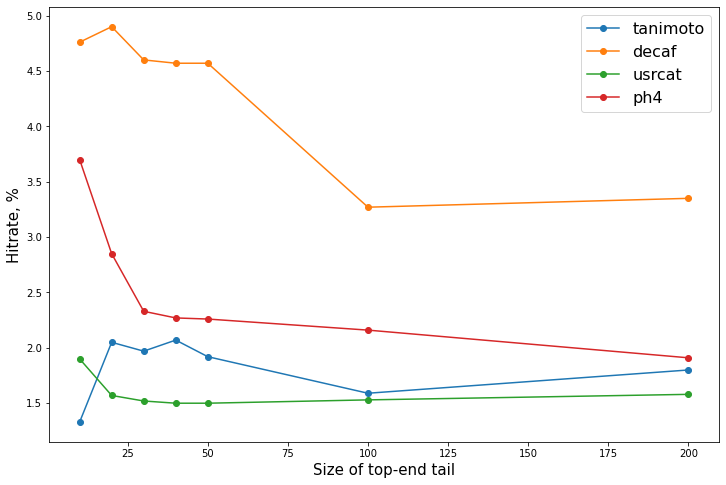

In [69]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
for label in mth.keys():
    x = mth[label].keys()
    y = mth[label].values()
    plt.plot(x,y, marker='o', label=label)
    
plt.legend(fontsize=16);
plt.xlabel('Size of top-end tail', fontsize=15)
plt.ylabel('Hitrate, %', fontsize=15);
# plt.savefig('figures/mapk1_eval_initial.png', bbox_width='tight')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

# Aggregated hitrate

Potential issue with previous hitrate: some references lead to highly correlated scores. To alleviate this, we evaluate the models by investigating the set of all unique molecules predicted (from all hypotheses) as hits rather than each hypothesis individually.

In [78]:
def get_agg_hitrate(method, threshold=None, nn=20):
    hits = select_hits(method, threshold=threshold, nn=nn)
    predicted_set = []
    active_set = []
    for k,v in hits.items():
        
        full_set = list(v['name'])
        label_set = list(v['label'])
        for a in full_set: 
            if a not in predicted_set: predicted_set.append(a)
        for ii, a in enumerate(full_set): 
            if a not in active_set and label_set[ii] == 'Active': active_set.append(a)
        
    rrr = round( 100 * len(active_set) / len(predicted_set) , 2 )
    print(f'top-{nn}', method, 'average hitrate:', rrr, '%', f'({len(active_set)} out of {len(predicted_set)})')
    return rrr

In [79]:
hits = get_agg_hitrate('usrcat', threshold=None, nn=20)

top-20 usrcat average hitrate: 1.73 % (26 out of 1502)


In [88]:
# inefficient and nonparallelized, takes a minute
mth = {}
methods = ['tanimoto', 'decaf', 'usrcat', 'ph4']
nums = [10, 20, 30, 40, 50, 100, 200]
for method in methods:
    for nn in nums:
        r = get_agg_hitrate(method, nn=nn)
        if method not in mth.keys():
            mth[method] = { nn : r }
        else:
            mth[method][nn] = r

top-10 tanimoto average hitrate: 1.69 % (11 out of 651)
top-20 tanimoto average hitrate: 1.66 % (20 out of 1208)
top-30 tanimoto average hitrate: 1.82 % (32 out of 1757)
top-40 tanimoto average hitrate: 1.96 % (44 out of 2250)
top-50 tanimoto average hitrate: 1.83 % (50 out of 2735)
top-100 tanimoto average hitrate: 1.7 % (83 out of 4889)
top-200 tanimoto average hitrate: 1.59 % (137 out of 8613)
top-10 decaf average hitrate: 4.44 % (21 out of 473)
top-20 decaf average hitrate: 3.85 % (33 out of 858)
top-30 decaf average hitrate: 3.57 % (43 out of 1203)
top-40 decaf average hitrate: 3.35 % (52 out of 1551)
top-50 decaf average hitrate: 3.35 % (63 out of 1882)
top-100 decaf average hitrate: 2.42 % (82 out of 3393)
top-200 decaf average hitrate: 2.23 % (131 out of 5885)
top-10 usrcat average hitrate: 2.15 % (17 out of 791)
top-20 usrcat average hitrate: 1.73 % (26 out of 1502)
top-30 usrcat average hitrate: 1.66 % (36 out of 2167)
top-40 usrcat average hitrate: 1.69 % (47 out of 2781)
to

/opt/anaconda3/envs/mol_clust/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_width" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.


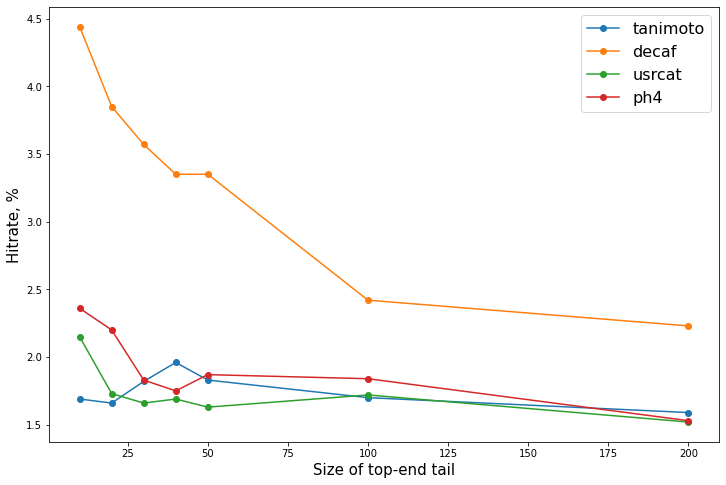

In [89]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
for label in mth.keys():
    x = mth[label].keys()
    y = mth[label].values()
    plt.plot(x,y, marker='o', label=label)
    
plt.legend(fontsize=16);
plt.xlabel('Size of top-end tail', fontsize=15)
plt.ylabel('Hitrate, %', fontsize=15);
plt.savefig('figures/mapk1_eval_aggregated.png', bbox_width='tight');

# Roughwork

In [94]:
df_dict['decaf'][df_dict['decaf']['6G93_A_EU2_ligand'] > 0.8]

name  6G93_A_EU2_ligand  1TVO_A_FRZ_ligand  \
672     28285_28309_Inactive              0.815              0.618   
1233    20642_20666_Inactive              0.832              0.597   
1369    37486_37515_Inactive              0.834              0.630   
1704    13101_13122_Inactive              0.892              0.661   
1837    31542_31566_Inactive              0.925              0.686   
...                      ...                ...                ...   
111895  31900_31924_Inactive              0.802              0.569   
111987  49103_49139_Inactive              0.891              0.682   
112541  45665_45701_Inactive              0.815              0.679   
113183  59260_59296_Inactive              0.839              0.701   
113564  35968_35995_Inactive              0.909              0.699   

        6G9J_A_ERK_ligand  2Y9Q_A_ANP_ligand  4QP7_A_363_ligand  \
672                 0.681              0.401              0.699   
1233                0.700              0.453              0.670   
1369                0.717              0.428              0.666   
1704                0.758              0.477              0.748   
1837                0.781              0.461              0.773   
...                   ...                ...                ...   
111895              0.686              0.407              0.610   
111987              0.768              0.447              0.740   
112541              0.687              0.498              0.766   
113183              0.706              0.447              0.797   
113564              0.772              0.433              0.761   

        5AX3_A_5ID_ligand  5BUJ_A_4VB_ligand  1WZY_A_F29_ligand  \
672                 0.548              0.595              0.598   
1233                0.595              0.565              0.580   
1369                0.531              0.604              0.614   
1704                0.622              0.637              0.643   
1837                0.599              0.664              0.665   
...                   ...                ...                ...   
111895              0.509              0.575              0.554   
111987              0.573              0.651              0.664   
112541              0.622              0.655              0.658   
113183              0.609              0.680              0.680   
113564              0.568              0.657              0.679   

        4QTA_A_38Z_ligand  ...  7NR3_A_UO5_ligand  6GDQ_A_EVK_ligand  \
672                 0.415  ...              0.644              0.528   
1233                0.410  ...              0.663              0.470   
1369                0.452  ...              0.683              0.551   
1704                0.467  ...              0.720              0.546   
1837                0.464  ...              0.741              0.644   
...                   ...  ...                ...                ...   
111895              0.400  ...              0.652              0.502   
111987              0.494  ...              0.732              0.590   
112541              0.455  ...              0.650              0.578   
113183              0.472  ...              0.669              0.579   
113564              0.466  ...              0.733              0.639   

        6G9M_A_ESW_ligand  7OPM_A_08G_ligand  4XJ0_A_41B_ligand  \
672                 0.668              0.543              0.697   
1233                0.687              0.536              0.677   
1369                0.705              0.518              0.699   
1704                0.745              0.543              0.742   
1837                0.767              0.588              0.807   
...                   ...                ...                ...   
111895              0.674              0.684              0.664   
111987              0.756              0.475              0.754   
112541              0.674              0.722              0.687   
113183              0.693             

{'6G93_A_EU2_ligand': Empty DataFrame
 Columns: [name, 6G93_A_EU2_ligand, 1TVO_A_FRZ_ligand, 6G9J_A_ERK_ligand, 2Y9Q_A_ANP_ligand, 4QP7_A_363_ligand, 5AX3_A_5ID_ligand, 5BUJ_A_4VB_ligand, 1WZY_A_F29_ligand, 4QTA_A_38Z_ligand, 2OJI_A_33A_ligand, 1PME_A_SB2_ligand, 2OJG_A_19A_ligand, 4QP2_A_36R_ligand, 4ZZO_A_CQ3_ligand, 5BVE_A_4VG_ligand, 3I5Z_A_Z48_ligand, 4FUY_A_EK2_ligand, 4QP4_A_36O_ligand, 4N0S_A_DHC_ligand, 5BUE_A_4V8_ligand, 5LCJ_A_6TS_ligand, 4FUX_A_E75_ligand, 3I60_A_E86_ligand, 3W55_A_1FM_ligand, 5BUI_A_4V9_ligand, 6G97_A_EQZ_ligand, 4FV0_A_EK3_ligand, 3TEI_A_ANP_ligand, 5WP1_A_B7S_ligand, 4FV3_A_EK6_ligand, 6GE0_A_EVQ_ligand, 4FV2_A_EK5_ligand, 6G9K_A_ESK_ligand, 3SA0_A_NRA_ligand, 4FV4_A_EK7_ligand, 6G9H_A_ERW_ligand, 4QP3_B_36Q_ligand, 5LCK_A_6TT_ligand, 6G91_A_EQW_ligand, 2OJJ_A_82A_ligand, 4FMQ_A_ANP_ligand, 4FV8_A_E63_ligand, 6G9A_A_ESQ_ligand, 4FV6_A_E57_ligand, 4G6N_A_EK0_ligand, 4QTE_A_390_ligand, 5K4I_A_6QB_ligand, 5NHJ_A_8XE_ligand, 4FV5_A_EK9_ligand, 4FV9_A_E71_lig

In [66]:
a = df_dict['decaf']
# a.head(30)

nan

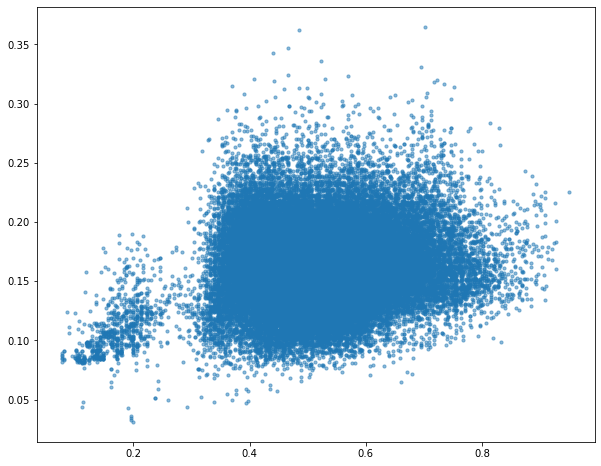

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

ref = '6G93_A_EU2_ligand'

x = np.array(df_dict['decaf'][ref])
y = np.array(df_dict['usrcat'][ref])
plt.scatter(x, y, s= 10, alpha=0.5);
np.corrcoef(x,y)[0][1]

In [22]:
df_dict['decaf'].corr()

6G93_A_EU2_ligand  1TVO_A_FRZ_ligand  6G9J_A_ERK_ligand  \
6G93_A_EU2_ligand           1.000000           0.544194           0.953699   
1TVO_A_FRZ_ligand           0.544194           1.000000           0.522049   
6G9J_A_ERK_ligand           0.953699           0.522049           1.000000   
2Y9Q_A_ANP_ligand           0.640485           0.668875           0.604057   
4QP7_A_363_ligand           0.749987           0.780103           0.700404   
...                              ...                ...                ...   
4XJ0_A_41B_ligand           0.827759           0.350618           0.804465   
7NR8_A_UOE_ligand           0.921397           0.501353           0.964506   
7NR5_A_UOH_ligand           0.911008           0.561879           0.961445   
6QAW_A_HVE_ligand           0.704968           0.709406           0.646034   
7NR9_A_UOW_ligand           0.951076           0.508844           0.992085   

                   2Y9Q_A_ANP_ligand  4QP7_A_363_ligand  5AX3_A_5ID_ligand  \
6G93_A_EU2_ligand           0.640485           0.749987           0.657564   
1TVO_A_FRZ_ligand           0.668875           0.780103           0.670440   
6G9J_A_ERK_ligand           0.604057           0.700404           0.603969   
2Y9Q_A_ANP_ligand           1.000000           0.838836           0.885426   
4QP7_A_363_ligand           0.838836           1.000000           0.905761   
...                              ...                ...                ...   
4XJ0_A_41B_ligand           0.502393           0.549035           0.481708   
7NR8_A_UOE_ligand           0.597002           0.661767           0.563993   
7NR5_A_UOH_ligand           0.648219           0.742668           0.643770   
6QAW_A_HVE_ligand           0.847910           0.941186           0.921210   
7NR9_A_UOW_ligand           0.598268           0.688152           0.591002   

                   5BUJ_A_4VB_ligand  1WZY_A_F29_ligand  4QTA_A_38Z_ligand  \
6G93_A_EU2_ligand           0.817250           0.549534           0.478313   
1TVO_A_FRZ_ligand           0.666926           0.994342           0.804271   
6G9J_A_ERK_ligand           0.805180           0.533640           0.491133   
2Y9Q_A_ANP_ligand           0.752623           0.667209           0.578538   
4QP7_A_363_ligand           0.870824           0.773581           0.614739   
...                              ...                ...                ...   
4XJ0_A_41B_ligand           0.621564           0.360453           0.328170   
7NR8_A_UOE_ligand           0.785626           0.514654           0.510260   
7NR5_A_UOH_ligand           0.854525           0.573923           0.513297   
6QAW_A_HVE_ligand           0.834682           0.703363           0.595187   
7NR9_A_UOW_ligand           0.807017           0.521009           0.485976   

                   2OJI_A_33A_ligand  ...  7NQQ_A_UMN_ligand  \
6G93_A_EU2_ligand           0.258903  ...           0.689930   
1TVO_A_FRZ_ligand           0.700363  ...           0.363385   
6G9J_A_ERK_ligand           0.266860  ...           0.726754   
2Y9Q_A_ANP_ligand           0.417079  ...           0.471195   
4QP7_A_363_ligand           0.498542  ...           0.555323   
...                              ...  ...                ...   
4XJ0_A_41B_ligand           0.081275  ...           0.547273   
7NR8_A_UOE_ligand           0.243937  ...           0.700801   
7NR5_A_UOH_ligand           0.296512  ...           0.700280   
6QAW_A_HVE_ligand           0.424069  ...           0.496490   
7NR9_A_UOW_ligand           0.254780  ...           0.719674   

                   7NR3_A_UO5_ligand  6GDQ_A_EVK_ligand  6G9M_A_ESW_ligand  \
6G93_A_EU2_ligand           0.494312           0.486941           0.948777   
1TVO_A_FRZ_ligand           0.753854           0.485854           0.525542   
6G9J_A_ERK_ligand           0.522597           0.474625           0.998627   
2Y9Q_A_ANP_ligand           0.383189           0.534478           0.600119   
4QP7_A_363_ligand           0.437000           0.

In [23]:
df_dict['usrcat'].corr()

6G93_A_EU2_ligand  1TVO_A_FRZ_ligand  6G9J_A_ERK_ligand  \
6G93_A_EU2_ligand           1.000000           0.730696          -0.208630   
1TVO_A_FRZ_ligand           0.730696           1.000000          -0.348807   
6G9J_A_ERK_ligand          -0.208630          -0.348807           1.000000   
2Y9Q_A_ANP_ligand           0.740638           0.374291           0.025792   
4QP7_A_363_ligand           0.577764           0.610375          -0.664051   
...                              ...                ...                ...   
4XJ0_A_41B_ligand           0.746918           0.697457           0.197422   
7NR8_A_UOE_ligand          -0.171638          -0.330886           0.973855   
7NR5_A_UOH_ligand          -0.146571          -0.312780           0.966706   
6QAW_A_HVE_ligand           0.583743           0.567173          -0.668096   
7NR9_A_UOW_ligand          -0.153864          -0.312989           0.973651   

                   2Y9Q_A_ANP_ligand  4QP7_A_363_ligand  5AX3_A_5ID_ligand  \
6G93_A_EU2_ligand           0.740638           0.577764           0.734641   
1TVO_A_FRZ_ligand           0.374291           0.610375           0.589519   
6G9J_A_ERK_ligand           0.025792          -0.664051          -0.591358   
2Y9Q_A_ANP_ligand           1.000000           0.320811           0.540484   
4QP7_A_363_ligand           0.320811           1.000000           0.906902   
...                              ...                ...                ...   
4XJ0_A_41B_ligand           0.640784           0.183409           0.287722   
7NR8_A_UOE_ligand           0.074853          -0.646652          -0.557421   
7NR5_A_UOH_ligand           0.085575          -0.642573          -0.548433   
6QAW_A_HVE_ligand           0.372274           0.929048           0.910153   
7NR9_A_UOW_ligand           0.088944          -0.644488          -0.554653   

                   5BUJ_A_4VB_ligand  1WZY_A_F29_ligand  4QTA_A_38Z_ligand  \
6G93_A_EU2_ligand           0.889212           0.755019          -0.247960   
1TVO_A_FRZ_ligand           0.708097           0.740601          -0.362968   
6G9J_A_ERK_ligand          -0.097499          -0.194369           0.941080   
2Y9Q_A_ANP_ligand           0.714094           0.510106          -0.055505   
4QP7_A_363_ligand           0.507752           0.461369          -0.672724   
...                              ...                ...                ...   
4XJ0_A_41B_ligand           0.821691           0.732402           0.131710   
7NR8_A_UOE_ligand          -0.074047          -0.192144           0.936884   
7NR5_A_UOH_ligand          -0.052324          -0.166176           0.936966   
6QAW_A_HVE_ligand           0.443299           0.402071          -0.682738   
7NR9_A_UOW_ligand          -0.056005          -0.174679           0.926219   

                   2OJI_A_33A_ligand  ...  7NQQ_A_UMN_ligand  \
6G93_A_EU2_ligand           0.691836  ...          -0.205145   
1TVO_A_FRZ_ligand           0.655847  ...          -0.350281   
6G9J_A_ERK_ligand           0.152935  ...           0.990106   
2Y9Q_A_ANP_ligand           0.574974  ...           0.038499   
4QP7_A_363_ligand           0.170384  ...          -0.656134   
...                              ...  ...                ...   
4XJ0_A_41B_ligand           0.919945  ...           0.201891   
7NR8_A_UOE_ligand           0.154563  ...           0.979398   
7NR5_A_UOH_ligand           0.179233  ...           0.973597   
6QAW_A_HVE_ligand           0.159170  ...          -0.661412   
7NR9_A_UOW_ligand           0.182247  ...           0.973449   

                   7NR3_A_UO5_ligand  6GDQ_A_EVK_ligand  6G9M_A_ESW_ligand  \
6G93_A_EU2_ligand           0.123497           0.064406           0.152054   
1TVO_A_FRZ_ligand          -0.054170          -0.099079          -0.081500   
6G9J_A_ERK_ligand           0.687648           0.848172           0.828683   
2Y9Q_A_ANP_ligand           0.328807           0.292626           0.370201   
4QP7_A_363_ligand          -0.477527          -0.

In [90]:
df_dict['tanimoto'].corr()

6G93_A_EU2_ligand  1TVO_A_FRZ_ligand  6G9J_A_ERK_ligand  \
6G93_A_EU2_ligand           1.000000           0.359102           0.720504   
1TVO_A_FRZ_ligand           0.359102           1.000000           0.240102   
6G9J_A_ERK_ligand           0.720504           0.240102           1.000000   
2Y9Q_A_ANP_ligand           0.426925           0.255412           0.420833   
4QP7_A_363_ligand           0.440788           0.674484           0.163013   
...                              ...                ...                ...   
7NR5_A_UOH_ligand           0.298898           0.238514           0.529121   
6QAW_A_HVE_ligand           0.473668           0.215573           0.272214   
7NR9_A_UOW_ligand           0.559173           0.146717           0.777846   
base_index                 -0.020200          -0.006329          -0.044594   
Max_Response               -0.047184          -0.104151          -0.004672   

                   2Y9Q_A_ANP_ligand  4QP7_A_363_ligand  5AX3_A_5ID_ligand  \
6G93_A_EU2_ligand           0.426925           0.440788           0.437266   
1TVO_A_FRZ_ligand           0.255412           0.674484           0.329865   
6G9J_A_ERK_ligand           0.420833           0.163013           0.348517   
2Y9Q_A_ANP_ligand           1.000000           0.216682           0.858636   
4QP7_A_363_ligand           0.216682           1.000000           0.289520   
...                              ...                ...                ...   
7NR5_A_UOH_ligand           0.336039           0.112250           0.303773   
6QAW_A_HVE_ligand           0.319925           0.464348           0.454785   
7NR9_A_UOW_ligand           0.449927           0.069702           0.417665   
base_index                 -0.029963           0.006055          -0.025179   
Max_Response               -0.059801          -0.082352          -0.069705   

                   5BUJ_A_4VB_ligand  1WZY_A_F29_ligand  4QTA_A_38Z_ligand  \
6G93_A_EU2_ligand           0.628041           0.243696           0.441088   
1TVO_A_FRZ_ligand           0.292332           0.857516           0.228821   
6G9J_A_ERK_ligand           0.345745           0.355805           0.541900   
2Y9Q_A_ANP_ligand           0.184771           0.299935           0.362548   
4QP7_A_363_ligand           0.586028           0.504082           0.221455   
...                              ...                ...                ...   
7NR5_A_UOH_ligand           0.118588           0.347297           0.314972   
6QAW_A_HVE_ligand           0.731011           0.180830           0.453770   
7NR9_A_UOW_ligand           0.213609           0.264115           0.434423   
base_index                 -0.024761          -0.014994          -0.038903   
Max_Response               -0.044577          -0.087331          -0.064501   

                   2OJI_A_33A_ligand  ...  6GDQ_A_EVK_ligand  \
6G93_A_EU2_ligand           0.239099  ...           0.198192   
1TVO_A_FRZ_ligand           0.415488  ...           0.320077   
6G9J_A_ERK_ligand           0.564544  ...           0.538013   
2Y9Q_A_ANP_ligand           0.106772  ...           0.212055   
4QP7_A_363_ligand           0.194559  ...           0.198812   
...                              ...  ...                ...   
7NR5_A_UOH_ligand           0.487871  ...           0.536445   
6QAW_A_HVE_ligand          -0.060085  ...          -0.018184   
7NR9_A_UOW_ligand           0.469765  ...           0.545820   
base_index                 -0.020200  ...          -0.019639   
Max_Response               -0.028211  ...          -0.026978   

                   6G9M_A_ESW_ligand  7OPM_A_08G_ligand  4XJ0_A_41B_ligand  \
6G93_A_EU2_ligand           0.720023           0.024578           0.697240   
1TVO_A_FRZ_ligand           0.237871           0.400923           0.230388   
6G9J_A_ERK_ligand           0.996216           0.427882           0.706757   
2Y9Q_A_ANP_ligand           0.418112           0.232903           0.473678   
4QP7_A_363_ligand           0.162451           0.